In [35]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from dataclasses import dataclass, field
from typing import List, Optional, Tuple
import numpy as np


crater_dtype = np.dtype([
('radius', 'f4'),          # float32 for crater radius
('y_position', 'f4'),      # float32 for y-axis position
('time_formed', 'i4'),     # int32 for timestamp
('depth', 'f4'),           # float32 for crater depth
])
    
@dataclass
class EDMState:
    # Time tracking
    time: int = 0 # Current time from start of simulation
    time_since_servo: int = 0 # Time since last servo action
    time_since_open_voltage: int = 0  # Time since last voltage was applied
    time_since_spark_ignition: int = 0 # Time since last spark was ignited
    time_since_spark_end: int = 0 # Time since last spark ended
    
    
    # Electrical state variables
    voltage: Optional[float] = None
    current: Optional[float] = None
    
    # Generator control state variables
    target_voltage: Optional[float] = None
    peak_current: Optional[float] = None
    OFF_time: Optional[float] = None
    ON_time: Optional[float] = None

    # Workpiece state variables
    
    workpiece_position: float = 0 # Current position of the workpiece
    
    # Wire state variables
    wire_position: float = 0.0 # Current position of the wire
    wire_velocity: float = 0.0 # Current velocity of the wire
    wire_unwinding_velocity = 0.2 # Unwinding velocity of the wire in micrometers per microsecond (microns/μs -- mm/ms .. m/s)
    
    
    craters_on_wire: np.ndarray = field(default_factory=lambda: np.array([], dtype=crater_dtype)) # List of craters on the wire (position, time, crater size, etc.)
    
    wire_average_temperature: float = 0.0 # Average temperature of the wire across the length
    
    
    # Spark state variables
    
    # Tuple to track current spark status (state, y-location, duration)
    # state: 0=No event, 1=Spark formation, -1=Short circuit, -2=Rest period
    # y_location: Position along wire length where spark is occurring (None if no spark)
    # duration: How many timesteps the current spark state has existed
    spark_status: List[Optional[float]] = field(default_factory=lambda: [0, None, 0])

    
    # Dielectric state variables
    
    dielectric_conductivity: float = 0.0 # Conductivity of the dielectric
    dielectric_temperature: float = 0.0 # Temperature of the dielectric
    
    # Servo state variables
    
    target_delta: float = 0.0 # Target change in position for the servo in the linear axis. This is the main servo control signal.
    
    # Process state
    is_wire_broken: bool = False
    is_wire_colliding: bool = False
    is_target_distance_reached: bool = False


class EDMModule:
    """Base class for all EDM simulation modules"""
    def __init__(self, env):
        self.env = env

    def update(self, state: EDMState) -> None:
        pass
    
class IgnitionModule(EDMModule):
    def __init__(self, env):
        super().__init__(env)
        self.lambda_cache = {}  # Cache for lambda values
        
    def update(self, state: EDMState) -> None:
        
        # First, unpack the generator control state
        target_voltage = state.target_voltage
        peak_current = state.peak_current
        ON_time = state.ON_time if state.ON_time is not None else 3  # Default to 3
        OFF_time = state.OFF_time if state.OFF_time is not None else 80  # Default to 80
        
                # check for short circuit
        if state.wire_position >= state.workpiece_position:
            state.spark_status = [-1, None, 0]
            state.voltage = 0
            state.current = 0
            return

        # Check spark status in the previous timestep
        spark_state, spark_location, spark_duration = state.spark_status
        # Suppose spark is already present, maintain it until current is cut
        
        if spark_state == 1: # If spark is happening
            state.spark_status = [1, spark_location, spark_duration + 1] # Increment counter
            if state.spark_status[2] >= ON_time: # End of spark duration
                state.spark_status[0] = -2 # Start rest period
                state.current = 0
                state.voltage = 0
            else:
                state.current = peak_current
                state.voltage = target_voltage * 0.3
            return
        
        if spark_state == -2: # If in rest period
            state.spark_status = [-2, None, spark_duration + 1]
            if state.spark_status[2] >= OFF_time + ON_time:  # End of rest period
                state.spark_status = [0, None, 0]
                state.voltage = target_voltage
                state.current = 0
            return
        
        if spark_state == 0: # No spark happening and not in rest period
            state.voltage = target_voltage
            state.current = 0
            # Calculate probability of new spark formation
            p_ignition = self._get_spark_conditional_probability(state)
    
            # Sample from probability distribution
            if self.env.np_random.random() < p_ignition:
                # Ignition occurs - randomly choose location along wire height
                spark_location = self.env.np_random.uniform(0, self.env.workpiece_height)
                state.spark_status = [1, spark_location, 0]
                state.voltage = state.target_voltage * 0.3  # Voltage drops during discharge
                state.current = state.peak_current
            else:
                # No ignition
                state.spark_status = [0, None, 0]
                state.voltage = state.target_voltage
                state.current = 0
    
    def _get_spark_conditional_probability(self, state):
        """ Calculate the conditional probability of sparking at a given microsecond,
        given that it has not sparked yet since the last voltage rise."""

        # In the case of the exponential distribution, the conditional
        # probability is just lambda
        return self._get_lambda(state)
    
    def _get_lambda(self, state):
        gap_distance = abs(state.workpiece_position - state.wire_position)
        # Check cache first
        if gap_distance in self.lambda_cache:
            return self.lambda_cache[gap_distance]
        # Calculate new lambda value and cache it
        lambda_value = np.log(2)/(0.48*gap_distance*gap_distance - 3.69*gap_distance + 14.05)
        self.lambda_cache[gap_distance] = lambda_value
        
        return lambda_value

# Add other modules similarly
class MaterialRemovalModule(EDMModule):
    def update(self, state):
        # Only remove material if there is an active spark that just started
        if state.spark_status[0] == 1 and state.spark_status[2] == 0:
            # Remove a constant amount of material by moving the workpiece position
            # away from the wire by a small fixed increment
            removal_rate = 0.01  # mm per spark
            state.workpiece_position += removal_rate

class DielectricModule(EDMModule):
    def update(self, state):
        # Your dielectric logic
        # For the moment leave blank
        pass

class WireModule(EDMModule):
    def __init__(self, env):
        super().__init__(env)
        self.wire_resistivity = 7.0e-8  # Resistivity of brass (ohm*m)
        self.wire_specific_heat = 380  # Specific heat of brass (J/kg*K)
        self.wire_density = 8400  # Density of brass (kg/m^3)
        self.wire_surface_area = np.pi * env.wire_diameter/1000 * env.workpiece_height/1000  # Surface area in contact with dielectric (m^2)
        self.heat_transfer_coeff = 1000  # Heat transfer coefficient to dielectric (W/m^2*K)
        self.ambient_temp = 293.15  # Ambient temperature (K)

    def update(self, state):
        ### THIS IS JUST A PLACEHOLDER IMPLEMENTATION ###
        # Calculate Joule heating power (P = I^2 * R)
        wire_cross_section = np.pi * (self.env.wire_diameter/2000)**2  # Convert mm to m
        wire_resistance = (self.wire_resistivity * self.env.workpiece_height/1000) / wire_cross_section
        joule_heating = state.current**2 * wire_resistance  # Power in watts
        
        # Calculate heat dissipation to dielectric
        temp_diff = state.wire_average_temperature - self.ambient_temp
        cooling_power = self.heat_transfer_coeff * self.wire_surface_area * temp_diff
        
        # Net heat change
        net_power = (joule_heating - cooling_power)
        
        # Calculate temperature change (dT = Q/(m*c))
        wire_mass = self.wire_density * wire_cross_section * (self.env.workpiece_height/1000)
        
        # Prevent division by zero or negative mass
        if wire_mass <= 0 or self.wire_specific_heat <= 0:
            temp_change = 0
        else:
            temp_change = (net_power * self.env.dt * 1e-6) / (wire_mass * self.wire_specific_heat)
        
        # Update wire temperature
        state.wire_average_temperature += temp_change
        # Prevent temperature from going below ambient
        state.wire_average_temperature = max(state.wire_average_temperature, self.ambient_temp)
        
class MechanicsModule(EDMModule):
    def update(self, state):
        # For the moment leave blank
        pass



class WireEDMEnv(gym.Env):    
    metadata = {"render_modes": ["human"], "render_fps": 300}
    
    def __init__(self, render_mode=None):
        self.render_mode = render_mode
        # Simulation parameters
        ## Internal timestep parameters
        self.dt = 1 # Base timestep (1μs)
        self.servo_interval = 1000 # Servo interval (1ms)
        
        ## Process configuration
        ### Workpiece physical properties
        self.workpiece_height = 10 # Height of workpiece (mm)
        self.workpiece_material = 'steel' # Material of workpiece
        #...
        
        ### Wire physical properties
        self.wire_material = 'brass'
        self.wire_diameter = 0.25 # Diameter of wire (mm)
        #...
        
        ### Dielectric physical properties
        self.dielectric_material = 'deionized water'
        
        self.state = EDMState() # Initialize state of the simulation
        
        self.ignition_module = IgnitionModule(self)
        self.material_removal_module = MaterialRemovalModule(self)
        self.dielectric_module = DielectricModule(self)
        self.wire_module = WireModule(self)
        self.mechanics_module = MechanicsModule(self)
        
        self.action_space = spaces.Dict({
            'servo': spaces.Box(
                low=np.array([-1.0]),
                high=np.array([1.0]),
                dtype=np.float32
            ),
            'generator_control': spaces.Dict({
                'target_voltage': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([200.0]),  # Placeholder max voltage
                    dtype=np.float32
                ),
                'peak_current': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([100.0]),  # Placeholder max current
                    dtype=np.float32
                ),
                 'ON_time': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([5.0]),  # Placeholder max on time
                    dtype=np.float32
                ),
                 'OFF_time': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([100.0]),  # Placeholder max off time
                    dtype=np.float32
                )
            })
        })
    
    def _check_termination(self):
        # Check for wire breakage
        if self.state.wire_position > self.workpiece_height:
            self.state.is_wire_broken = True
            return True
        
        # Check for target distance reached
        if self.state.workpiece_position >= self.state.target_delta:
            self.state.is_target_distance_reached = True
            return True
        
        return False
    
    def _get_obs(self):
        return None
        
    def _calculate_reward(self):
        return 0
    
    def step(self, action):
        # Track if this is a control step (every 1ms / 1000μs)
        is_control_step = self.state.time_since_servo >= self.servo_interval
        
        # Only process actions on control steps
        if is_control_step:
            self.state.target_delta = action['servo'][0]
            self.state.target_voltage = action['generator_control']['target_voltage'][0]
            self.state.peak_current = action['generator_control']['peak_current'][0]
            self.state.ON_time = action['generator_control']['ON_time'][0]  # Add these two lines
            self.state.OFF_time = action['generator_control']['OFF_time'][0]
            self.state.time_since_servo = 0  # Reset timer
        
        # Sequential process updates
        self.ignition_module.update(self.state)
        self.material_removal_module.update(self.state)
        self.dielectric_module.update(self.state)
        self.wire_module.update(self.state)
        if self.state.is_wire_broken:
            # If the wire is broken, return immediately
            return None, 0, True, False, {'wire_broken': True}
        self.mechanics_module.update(self.state)
        
        # Update time trackers
        self.state.time += self.dt
        self.state.time_since_servo += self.dt
        self.state.time_since_open_voltage += self.dt
        
        if self.state.spark_status[0] == 1:
            self.state.time_since_spark_ignition += self.dt
            self.state.time_since_spark_end = 0
        else:
            self.state.time_since_spark_end += self.dt
            self.state.time_since_spark_ignition = 0
        
        # Only return meaningful observations and calculate rewards on control steps
        if is_control_step:
            observation = self._get_obs()
            reward = self._calculate_reward()
            self.previous_target_current = self.state.peak_current
        else:
            observation = None
            reward = 0
        
        terminated = self._check_termination()
        truncated = False
        
        info = {
            'wire_broken': self.state.is_wire_broken,
            'target_reached': self.state.is_target_distance_reached,
            'spark_status': self.state.spark_status[0],
            'time': self.state.time,
            'is_control_step': is_control_step
        }
        
        return observation, reward, terminated, truncated, info


Simulation took 0.9299070835113525 seconds


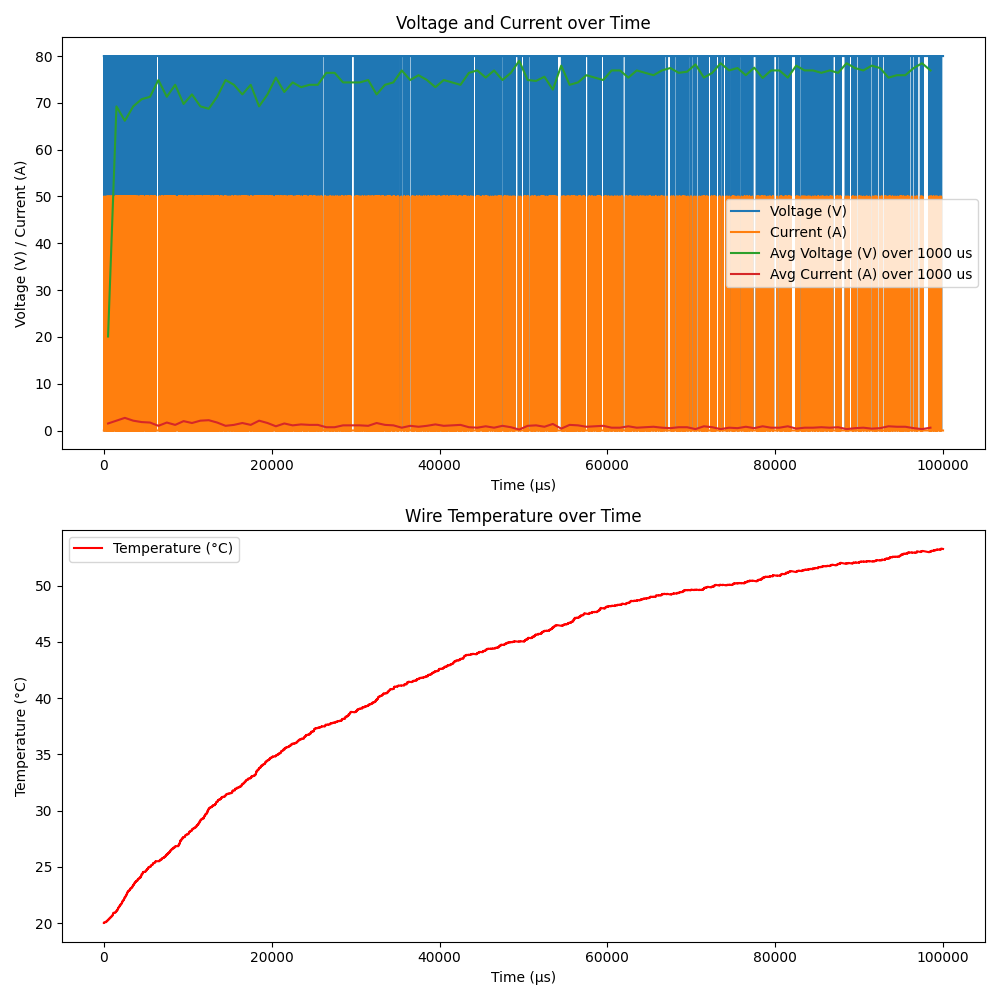

In [40]:
import matplotlib.pyplot as plt
import time
import numpy as np
%matplotlib widget
env = WireEDMEnv()
env.state.workpiece_position = 10
env.state.wire_position = 0
env.state.target_voltage = 80
env.state.peak_current = 50
env.state.OFF_time = 80

voltage_history = []
current_history = []
time_history = []
temperature_history = []

start_time = time.time()
for i in range(100000): # 10 seconds of simulation at 1us timesteps
    action = {
        'servo': np.array([0.0], dtype=np.float32),
        'generator_control': {
            'target_voltage': np.array([80.0], dtype=np.float32),
            'peak_current': np.array([50.0], dtype=np.float32),
            'ON_time': np.array([2.0], dtype=np.float32),
            'OFF_time': np.array([5.0], dtype=np.float32)
        }
    }
    env.step(action)
    voltage_history.append(env.state.voltage)
    current_history.append(env.state.current)
    time_history.append(env.state.time)
    temperature_history.append(env.state.wire_average_temperature)
end_time = time.time()
print(f"Simulation took {end_time - start_time} seconds")

# Calculate average voltage and current over 1000 us windows
window_size = 1000
avg_voltage_history = []
avg_current_history = []
avg_time_history = []

for i in range(0, len(voltage_history) - window_size, window_size):
    avg_voltage_history.append(np.mean(voltage_history[i:i+window_size]))
    avg_current_history.append(np.mean(current_history[i:i+window_size]))
    avg_time_history.append(np.mean(time_history[i:i+window_size]))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot voltage and current on first subplot
ax1.plot(time_history, voltage_history, label="Voltage (V)")
ax1.plot(time_history, current_history, label="Current (A)")
ax1.plot(avg_time_history, avg_voltage_history, label="Avg Voltage (V) over 1000 us")
ax1.plot(avg_time_history, avg_current_history, label="Avg Current (A) over 1000 us")
ax1.set_xlabel("Time (μs)")
ax1.set_ylabel("Voltage (V) / Current (A)")
ax1.set_title("Voltage and Current over Time")
ax1.legend()

# Plot temperature on second subplot
ax2.plot(time_history, [temp - 273.15 for temp in temperature_history], label="Temperature (°C)", color='red')
ax2.set_xlabel("Time (μs)")
ax2.set_ylabel("Temperature (°C)")
ax2.set_title("Wire Temperature over Time")
ax2.legend()

plt.tight_layout()
plt.show()
